# Bjorkman custom analyses

In [1]:
import os

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import sklearn
import scipy.stats

import svgutils

import yaml

Read in configuration and PSE config:

In [2]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory

In [3]:
resultsdir = '../results/bjorkman_custom_analyses'
os.makedirs(resultsdir, exist_ok=True)

## Make input file for `custom_logo_overlays`

Make a CSV file that has for every monoclonal antibody in the Bjorkman panel, the total escape at each site (`site_total_escape_frac_epistasis_model`).
Note that this needs to be in 'wide' format. 
* site_col: site
* antibody_col: null
* val_col: # here is 
* missing_vals:

In [4]:
# parameterize
barnes_antibodies = ['C105', 'C002', 'C121', 'C144', 'C135', 'C110']
conditions_to_keep = [i+'_400' for i in barnes_antibodies] + ['COV-021_500', 'COV-047_200', 'COV-057_50', 'COV-072_200', 'COV-107_80']
metric = "site_total_escape_frac_epistasis_model"
site_total_escape_file = os.path.join(resultsdir, 'site_total_escape.csv')

In [5]:
escape_fracs = (pd.read_csv(os.path.join('../', config['escape_fracs']))
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame:')
display(HTML(escape_fracs.head().to_html(index=False)))

# pivot table to wide format
site_total_escape = (escape_fracs
                     .query('condition in @conditions_to_keep')
                     [['condition', 'site', 'site_total_escape_frac_epistasis_model']]
                     .drop_duplicates()
                     .pivot(index="site", columns="condition", values=metric)
                     .reset_index()
                    )
print('First few lines of site-total escape data frame:')
display(HTML(site_total_escape.head().to_html(index=False)))

print(f'Writing file to {site_total_escape_file}')
site_total_escape.to_csv(site_total_escape_file, index=False)

First few lines of escape-fraction data frame:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
C002_400,331,N,A,E,331,0.002089,0.000792,0.03321,0.01876,0.002076,0.001173,2
C002_400,331,N,D,E,331,0.001883,0.001079,0.03321,0.01876,0.002076,0.001173,1
C002_400,331,N,E,E,331,0.002089,0.001067,0.03321,0.01876,0.002076,0.001173,2
C002_400,331,N,F,E,331,0.002089,0.000501,0.03321,0.01876,0.002076,0.001173,2
C002_400,331,N,G,E,331,0.002089,0.000479,0.03321,0.01876,0.002076,0.001173,2


First few lines of site-total escape data frame:


condition,site,C002_400,C105_400,C110_400,C121_400,C135_400,C144_400,COV-021_500,COV-047_200,COV-057_50,COV-072_200,COV-107_80
,331,0.03321,0.02230,0.02069,0.04289,0.02573,0.02512,0.02915,0.01458,0.01453,0.02999,0.3008
,332,0.03968,0.02645,0.02428,0.03922,0.02921,0.03514,0.05853,0.07185,0.02962,0.14670,0.6547
,333,0.03759,0.02506,0.02305,0.03836,0.02890,0.02913,0.02755,0.01679,0.01438,0.04162,0.3481
,334,0.03760,0.02506,0.02514,0.03796,0.04176,0.03171,0.05825,0.07936,0.04348,0.15020,0.5460
,335,0.03968,0.02645,0.02429,0.04126,0.03158,0.03154,0.07135,0.05260,0.03389,0.18480,0.6426


Writing file to ../results/bjorkman_custom_analyses/site_total_escape.csv


## Plot site-level correlations between antibodies and their sera

In the cell above, I have already created the `site_total_escape` dataframe that has site-level escape metric. 
I just need to get correlations between the antibodies and their sera now. 

In [6]:
short_names = {k:k.split('_')[0] for k in conditions_to_keep}

sera_mab_mapping = {'C002': 'COV-021', 
                    'C144': 'COV-047', 
                    'C135': 'COV-072', 
                    'C105': 'COV-107',
                    'C121': 'COV-107',
                    'C110': 'COV-107',
                   }

site_escape_wide = (site_total_escape
                    .rename(columns=short_names)
                   )
display(HTML(site_escape_wide.head().to_html(index=False)))

condition,site,C002,C105,C110,C121,C135,C144,COV-021,COV-047,COV-057,COV-072,COV-107
,331,0.03321,0.02230,0.02069,0.04289,0.02573,0.02512,0.02915,0.01458,0.01453,0.02999,0.3008
,332,0.03968,0.02645,0.02428,0.03922,0.02921,0.03514,0.05853,0.07185,0.02962,0.14670,0.6547
,333,0.03759,0.02506,0.02305,0.03836,0.02890,0.02913,0.02755,0.01679,0.01438,0.04162,0.3481
,334,0.03760,0.02506,0.02514,0.03796,0.04176,0.03171,0.05825,0.07936,0.04348,0.15020,0.5460
,335,0.03968,0.02645,0.02429,0.04126,0.03158,0.03154,0.07135,0.05260,0.03389,0.18480,0.6426


In [7]:
# Get correlations
corr_df = pd.DataFrame()
for i in sera_mab_mapping.keys():
    corrs = (
        site_escape_wide
        [[i, sera_mab_mapping[i]]]
        .corr(method='pearson')
        .reset_index()
        .query('condition == @i'))
    corrs.columns=['mab','to_drop','corr_float']
    corrs=(corrs
           .drop(columns=['to_drop'])
           .assign(plot=f'{sera_mab_mapping[i]}\n{i}',
                   corr=lambda x: 'R='+x['corr_float'].round(2).astype(str)
                  )
           .drop(columns=['mab'])
          )
    print(corrs)
    corr_df = pd.concat([corr_df, corrs], ignore_index=True)
print(corr_df)

   corr_float           plot    corr
0    0.751667  COV-021\nC002  R=0.75
   corr_float           plot   corr
0    0.804689  COV-047\nC144  R=0.8
   corr_float           plot    corr
0     0.05662  COV-072\nC135  R=0.06
   corr_float           plot    corr
0     0.29245  COV-107\nC105  R=0.29
   corr_float           plot    corr
0    0.473392  COV-107\nC121  R=0.47
   corr_float           plot    corr
0    0.452437  COV-107\nC110  R=0.45
   corr_float           plot    corr
0    0.751667  COV-021\nC002  R=0.75
1    0.804689  COV-047\nC144   R=0.8
2    0.056620  COV-072\nC135  R=0.06
3    0.292450  COV-107\nC105  R=0.29
4    0.473392  COV-107\nC121  R=0.47
5    0.452437  COV-107\nC110  R=0.45


Make plots, labeling key sites

In [8]:
# read in color scheme
color_scheme = 'barnes_classes'
color_scheme_file = os.path.join('..',config['site_color_schemes'])
color_scheme_df = (pd.read_csv(color_scheme_file))[['site', color_scheme]]
color_scheme_df.columns=['site','color']

colors = sorted(color_scheme_df['color'].unique().tolist())
print(colors)

display(HTML(color_scheme_df.head().to_html(index=False)))

['#66CCEE', '#6A0DAD', '#808080', '#A81AA1', '#E52794']


site,color
331,#808080
332,#808080
333,#808080
334,#808080
335,#808080


Saving to ../results/bjorkman_custom_analyses/serum_mab_corr.pdf
First few lines of site-total escape data frame:


,site,label_site,mab_site_escape,serum_site_escape,plot,color
0,331,N331,0.03321,0.02915,COV-021\nC002,#808080
1,332,I332,0.03968,0.05853,COV-021\nC002,#808080
2,333,T333,0.03759,0.02755,COV-021\nC002,#808080
3,334,N334,0.03760,0.05825,COV-021\nC002,#808080
4,335,L335,0.03968,0.07135,COV-021\nC002,#808080


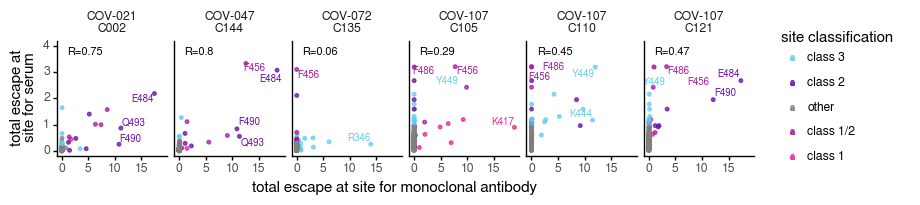

In [9]:
# set thresholds for labeling key sites
mab_escape_min=10
serum_escape_min=3

plot_df = (escape_fracs
           .query('condition in @conditions_to_keep')
           [['condition', 'site', 'wildtype', 'site_total_escape_frac_epistasis_model']]
           .drop_duplicates()
           .replace(short_names)
           .assign(label_site=lambda x: x['wildtype']+x['site'].astype(str))
          )


plot_corrs_df = pd.DataFrame()
full_label_df = pd.DataFrame()

for i in sera_mab_mapping.keys():
    mab=i
    serum=sera_mab_mapping[i]

    temp_df=(plot_df
             .query('condition==@mab or condition==@serum')
             .pivot(index=["site","label_site"], columns="condition", values=metric)
             .reset_index()
            )
    temp_df.columns=['site','label_site','mab_site_escape','serum_site_escape']
    temp_df = (temp_df
               .assign(plot=f'{serum}\n{mab}')
               .merge(color_scheme_df, how='left', on='site')
              )
    
    label_df = (temp_df
                .query(f"(mab_site_escape>{mab_escape_min}) or (serum_site_escape > {serum_escape_min})")
               )
    
    plot_corrs_df = pd.concat([plot_corrs_df, temp_df], ignore_index=True)
    full_label_df = pd.concat([full_label_df, label_df], ignore_index=True)

p = (ggplot(plot_corrs_df) +
     aes(x='mab_site_escape', y='serum_site_escape', color='color') +
     geom_point(size=1, alpha=0.75) +
     geom_text(data=full_label_df,
               mapping=aes(label='label_site', color='color'),
               size=7,
               adjust_text={'expand_points': (1.05, 1.2),
                            'expand_text': (1.05, 1.2)},
               ) +
     geom_text(data=corr_df,
               mapping=aes(label='corr', x=1, y=3.75),
               color='black',
               size=8,
               ha='left'
               ) +
     facet_wrap('~plot', ncol=6) +
     theme_classic() +
     theme(figure_size=(6*1.5,1*1.5), 
           strip_margin=0.35,
           strip_background=element_blank(),
           text=element_text(family='FreeSans'),
          ) +
     scale_y_continuous(limits=[0,4]) +
     xlab('total escape at site for monoclonal antibody')+
     ylab(f'total escape at\nsite for serum') +
     scale_color_manual(values=colors,
                        name='site classification',
                        labels=['class 3', 'class 2', 'other', 'class 1/2', 'class 1']
                       )
    )
_ = p.draw()

plotfile = f'{resultsdir}/serum_mab_corr.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)
    
print('First few lines of site-total escape data frame:')
display(HTML(plot_corrs_df.head().to_html(index=True)))